# Comparing $PM_1$ Calculation Methods

Here, our goal is to evaluate how well our $PM_1$ calculation methods worked. 

## Method 1: C-PM1 - ACSM+BC

Here, we simply sum the mass from the ACSM and the Aethalometer. Gani et al (2018) refer to this as C-PM1.

## Method 2: Fit and Extrapolate the SMPS Scan

Assume the distribution in volume-weighted space is a single log-normal mode. Fit the data to a log-normal distribution and then extrapolate to 1 micron. 

We generated the fit earlier, here we are simply plotting the data.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import smps
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import matplotlib.gridspec as gridspec
import smps

sns.set("paper", "ticks", font_scale=1.25)
smps.set()

%matplotlib inline

# Method 1: C-PM1

In [2]:
df1 = pd.read_feather(Path().resolve().parent.joinpath("data/munged/utaustin.complete.feather"))

df1.set_index("index", inplace=True)

df1["CPM1"] = df1[["org", "nh4", "so4", "no3", "chl", "bc"]].sum(axis=1, skipna=False)

## Method 2: Fit and Extrapolate the SMPS Scan

The general idea here is that we fit a single lognormal mode to each SMPS scan in volume space. We can then integrate between 0-1 $\mu m$ to get the total volume which can then be multiplied by the density to get a mass loading. Density here is taken from a paper on Delhi which says 1.2g/cm3 is a good approximation.

## Load the data

In [4]:
# load the underlying scans
s = joblib.load(Path().resolve().parent.joinpath("data/munged/smps.data.munged.sav"))


# load the fitted data values
df2 = pd.read_feather(Path().resolve().parent.joinpath("data/munged/smps.data.fitted.feather")).set_index("index")

## Fit the Mean SMPS Scan

Here, we will use the py-smps library to fit the volume-weighted, mean SMPS scan to a single lognormal mode.

In [5]:
from smps.fit import LogNormal

model = LogNormal()

X = s.midpoints
Y = s.dvdlogdp.mean()

results = model.fit(X, Y, modes=1)

print (results.summary())

                              LogNormalFitResults                               
                          N (cm-3)            GM (nm)               GSD         
--------------------------------------------------------------------------------
       Mode 0        1.25e+02 (2.2e-01)   380.94 (5.0e-01)     1.93 (2.3e-03)   
--------------------------------------------------------------------------------


In [6]:
# merge the two dataframes together
df4 = pd.merge(df1[["CPM1"]], df2[["PM1_EST"]], left_index=True, 
               right_index=True, how="outer").resample("5min").mean().dropna()

## Plot the Distribution

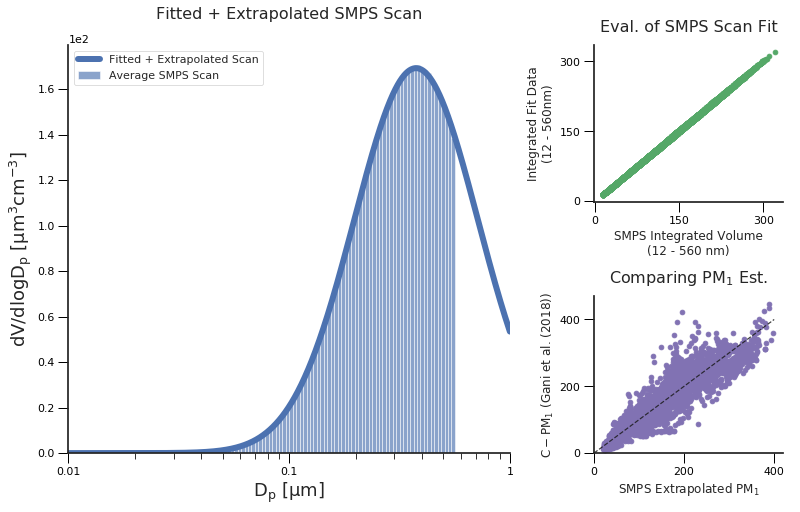

In [112]:
fig = plt.figure(figsize=(11, 7), constrained_layout=True)
gs = fig.add_gridspec(2, 10)
ax1 = fig.add_subplot(gs[0:, 0:7])
ax2 = fig.add_subplot(gs[0, 7:])
ax3 = fig.add_subplot(gs[1, 7:])

# plot the mean SMPS scan
ax1 = smps.plots.histplot(s.dvdlogdp, s.bins, ax=ax1, plot_kws=dict(alpha=.65))

# plot the fitted data on top of the actual SMPS data
ax1.plot(np.logspace(-2, 0, 1000), results.predict(np.logspace(-2, 0, 1000)), lw=6)
ax1.set_xlabel("$D_p$ [$\mu m$]", fontsize=18)
ax1.set_ylabel("$dV/dlogD_p$ [$\mu m^3 cm^{-3}$]", fontsize=18)
ax1.set_title("Fitted + Extrapolated SMPS Scan", fontsize=16, y=1.05)
ax1.set_xlim(.01, 1)
# ax1.annotate("Avg. SMPS Scan", xy=(.2, 60), xytext=(.03, 80), 
#              arrowprops=dict(facecolor='black', shrink=0.05), fontsize=16)
ax1.legend(["Fitted + Extrapolated Scan", "Average SMPS Scan"])

# plot the Fit vs Measured PM1
ax2.scatter(df2["Measured_PM"], df2["Fit_PM"], c="g")
ax2.set_xlabel("SMPS Integrated Volume\n(12 - 560 nm)")
ax2.set_ylabel("Integrated Fit Data\n(12 - 560nm)")
ax2.set_title("Eval. of SMPS Scan Fit", fontsize=16, y=1.05)
ax2.set_xticks([0, 150, 300])
ax2.set_yticks([0, 150, 300])

# plot the SMPS vs CPM1 values
df4 = pd.merge(df1[["CPM1"]], df2[["PM1_EST"]], left_index=True, 
               right_index=True, how="outer").resample("5min").mean().dropna()
ax3.scatter(df4["PM1_EST"], df4["CPM1"], c='m')
ax3.plot([0, 400], [0, 400], "k--", alpha=.85)
ax3.set_xlabel("SMPS Extrapolated $PM_1$")
ax3.set_ylabel("$C-PM_1$ (Gani et al. (2018))")
ax3.set_xticks([0, 200, 400])
ax3.set_yticks([0, 200, 400])
ax3.set_xlim(0, None)
ax3.set_ylim(0, None)
ax3.set_title("Comparing $PM_1$ Est.", y=1.05, fontsize=16)

sns.despine()

fig.savefig("Comparing PM1 Estimation Methods.png", dpi=350)